# Is competitive CS:GO scene still growing? How competitive CS:GO has changed? Predicting CS:GO match outcome.

In this analysis, I will use 3 datasets.
    - CS:GO Events  - dataset with LAN events since 2012 (first CS:GO tournament)
    - CS:GO Ranking - HLTV ranking, since October 2015
    - CS:GO Matches - competitive matches since January 2016 - extended aftermatch data from the demo file has been introduced
All data has been scraped from www.hltv.org.

# Abstract

A goal of this analysis is to explore some basic information about CS:GO competitive scene. At the end I will try to use available pieces of information to predict the outcome of the CS:GO match.

# Table of content
* [All datasets have been previously cleaned](#Table-of-content)
    * [Cleaning events dataset](https://www.kaggle.com/twistplot/cs-go-event-dataset-cleaning?scriptVersionId=6412209)
    * [Cleaning ranking dataset](https://www.kaggle.com/twistplot/cs-go-hltv-ranking-basic-cleaning)
    * [Cleaning matches dataset](https://www.kaggle.com/twistplot/cs-go-matches-dataset-basic-cleaning?scriptVersionId=6412200)
*    [Exploring events dataset](#Exploring-events-dataset)
    *      [Importing libraries](#Importing-libraries)
    *      [Event count by year](#Events-count-by-year)
    *      [Event count by event type](#Events-count-by-event-type)
    *      [Money prize by year](#Money-prize-by-year)
    *      [Average money prizes by event type by year](#Average-money-prizes-by-event-type-by-year)
*    [Exploring ranking dataset](#Exploring-ranking-dataset)
*    [Exploring matches dataset](#Exploring-ranking-dataset)
    *      [Matches type distribution](#Matches-type-distribution)
    *      [Matches and team count by year](#Matches-and-team-count-by-year)
    *      [Exploring CS:GO maps](#Exploring-maps)
    *      [Does side on particular map matter?](#Does-it-matter-whether-we-play-counter-terrorist-or-terrorist-side-on-a-particular-map?)
    *      [First-half advantage - guarantee of winning?](#Does-the-advantage-after-the-first-half-guarantee-winning-the-map?)
*      [Predicting match outcome](#Predicting-match-outcome)
    *    [Feature engineering](#Feature-engineering)
    *    [Preparing data for prediction model](#Preparing-data-for-prediction-model)
    *    [Predicting match based on half time score](#Predicting-match-based-on-half-time-score)
    *    [XGBOOSTING Matches](#XGBOOSTING-Matches)
    *    [XGBOOST Tuning](#XGBOOST-Tuning)
    *    [Multilayer perceptron](#Multilayer-perceptron)

# Exploring events dataset
[Table of content](#Table-of-content)

## Importing libraries
[Table of content](#Table-of-content)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import matplotlib.patches as mpatches

In [2]:
EVENT_PATH = '../input/cleaned-csgo-events/cs_go_events_cleaned.csv'

In [3]:
df = pd.read_csv(EVENT_PATH)

In [4]:
df.head(3)

,event_link,event_name,event_teams_count,event_prize,event_type,prize_pool,location,teams_placement_list,year,month,day,prize_money,country,city
0,http://hltv.org/events/4061/wesg-2018-brunei-r...,WESG 2018 Brunei Regional Finals,4,Other,Local LAN,"$1,500 + 1 spot at WESG 2018 SEA Regional Finals","Gadong, Brunei |","[[['1st'], ['ExidiuM'], [], ['Brunei'], ['/tea...",2018,9,30,1500,Brunei,Gadong
1,http://hltv.org/events/4068/lets-play-czestochowa,Let's Play Czestochowa,4,"$3,645",Local LAN,"$3,645","Czestochowa, Poland |","[[['1st'], ['FAM'], ['$2,700'], ['Poland'], ['...",2018,9,16,3645,Poland,Czestochowa
2,http://hltv.org/events/4070/balkan-legends,Balkan Legends,4,"$2,327",Reg. LAN,"$2,327","Thessaloniki, Greece |","[[['1st'], ['UltiCoin'], ['$1,163'], ['Serbia'...",2018,9,16,2327,Greece,Thessaloniki


## Events count by year
[Table of content](#Table-of-content)

Let's see if the CS:GO scene has grown over the past years.

In [5]:
df.groupby('year').count()['event_link'].reset_index()
years_df = df.groupby('year').count().reset_index()
years, years_count = years_df.year, years_df.event_link

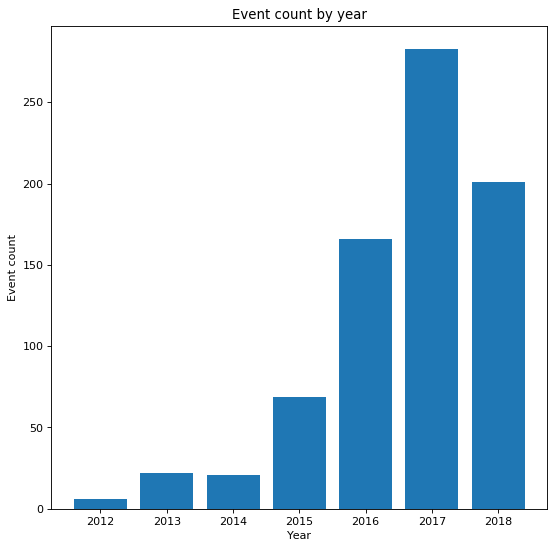

In [6]:
plt.figure(figsize=(8, 8), dpi=80)
plt.bar(years, years_count)
plt.xlabel('Year')
plt.ylabel('Event count')
plt.title('Event count by year')
plt.show()

Looks like fast CS:GO scene growth since 2014 stopped this year. We still have some time till the end of this year but event count will be similar as in 2017. Beside online games and tournaments (not included in this dataset) we have four types of LAN events. Local LAN, regional LAN, international LAN, major tournament.

## Events count by event type
[Table of content](#Table-of-content)

Let's see how the distribution of different events type looks like.

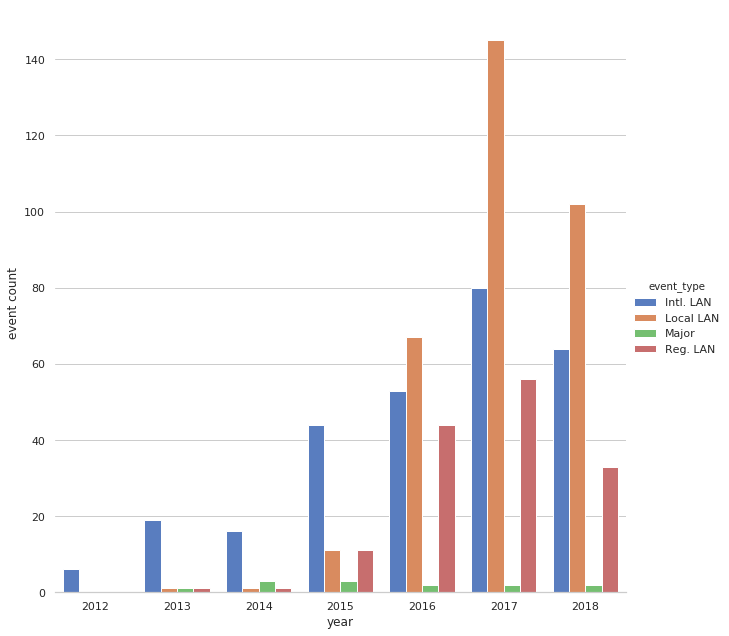

In [7]:
event_type_by_year = df.groupby(['event_type', 'year']).count().reset_index()
sns.set(style="whitegrid")
g = sns.catplot(x="year", y="event_link", hue="event_type", data=event_type_by_year, height=9, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("event count")

Local lans gained a lot of new events in 2016 and 2017, but in general, the biggest increase was between 2014-2017.

## Money prize by year
[Table of content](#Table-of-content)

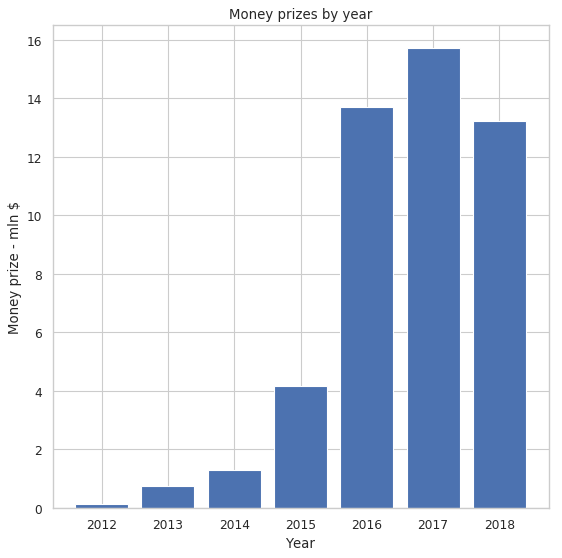

In [8]:
money_year = df.groupby('year').count().reset_index()
money_by_year = df.groupby(['year']).sum()['prize_money'].reset_index()
plt.figure(figsize=(8, 8), dpi=80)
plt.bar(money_by_year.year, money_by_year.prize_money/1000000)
plt.xlabel('Year')
plt.ylabel('Money prize - mln $')
plt.title('Money prizes by year')
plt.show()

Money prizes also reached their peak in 2017, the biggest growth was between 2015-2016. Till the end of 2018, there are no more tournaments with big money prizes, so total prize money will be similar as in 2017.

## Average money prizes by event type by year
[Table of content](#Table-of-content)

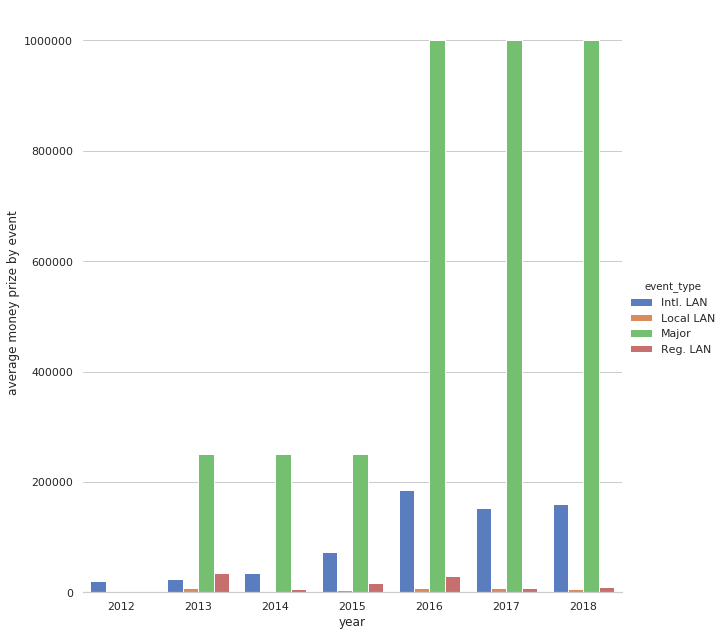

In [9]:
x = df.groupby(['event_type', 'year']).sum()['prize_money']/df.groupby(['event_type', 'year']).count()['event_link']
money_by_event_by_year = x.reset_index() # inplace=True - > TypeError: Cannot reset_index inplace on a Series to create a DataFrame
money_by_event_by_year.columns.values
money_by_event_by_year.columns = ['event_type', 'year', 'average_money']

sns.set(style="whitegrid")
g = sns.catplot(x="year", y="average_money", hue="event_type", data=money_by_event_by_year, height=9, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("average money prize by event")

Large average increase is on major tournament - prize pool has increased four times in 2016|. Local and regional lans are not focused on money prizes, looks like the main prize in these competitions is spot on more significant competitions (local>regional>international>major).

# Exploring ranking dataset
[Table of content](#Table-of-content)

In [10]:
RANKING_PATH = '../input/cleaned-csgo-rankings/cs_go_hltv_ranking_clean.csv'

# Exploring matches dataset
[Table of content](#Table-of-content)

In [11]:
MATCHES_PATH = '../input/cleaned-csgo-matches/cs_go_matches_cleaned.csv'

df = pd.read_csv(MATCHES_PATH, low_memory=False)

df.columns.values

print("Maps played: "+str(df.shape[0]))
print("Matches: "+str(len(df.match_id.unique())))

Maps played: 39381
Matches: 24015


In CS:GO match dataset 39381 maps are played in 24015 matches. There are several types of matches on the CS: GO tournament stage - Best of(BO) 1, BO2, BO3, BO5. Let's see how the distribution of different types of matches looks.

## Matches type distribution
[Table of content](#Table-of-content)

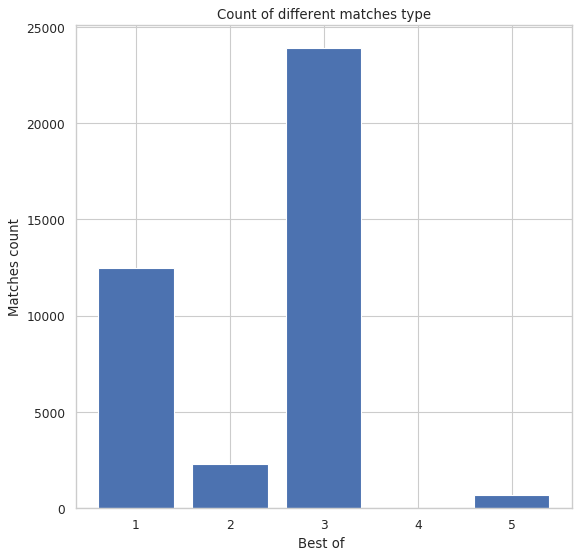

In [12]:
matches_type = df.best_of.value_counts().reset_index()
matches_type.columns = ['best_of_type', 'best_of_count']
matches_type = df.best_of.value_counts().reset_index()
matches_type.columns = ['best_of_type', 'best_of_count']
plt.figure(figsize=(8, 8), dpi=80)
plt.bar(matches_type.best_of_type, matches_type.best_of_count)
plt.xlabel('Best of ')
plt.ylabel('Matches count')
plt.title('Count of different matches type')
plt.show()

In [13]:
len(df[df.best_of == 3]) / len(df.best_of)

0.6073233285086717

Most popular type is best of 3 (~61%), good for different tournament formats - eliminates randomity playing one map which could not be good for one of the teams at the moment, but also isn't too long - as playing one map takes about 40-50 minutes. The least popular is best of 5 type. It is often played as the final of the tournament.

## Matches and team count by year 
[Table of content](#Table-of-content)

In [14]:
matches_count_2016 = len(df[df.year == 2016].match_id.unique())
matches_count_2017 = len(df[df.year == 2017].match_id.unique())
matches_count_2018 = len(df[df.year == 2018].match_id.unique())
print("Matches in 2016: " + str(matches_count_2016) )
print("Matches in 2017: " + str(matches_count_2017) )
print("Matches in 2018: " + str(matches_count_2018) )

Matches in 2016: 6486
Matches in 2017: 10461
Matches in 2018: 7068


Big increase in 2017 is partly because of big local lans increase. This growth is a year after the prize pool has increased in 2016 almost 3 times in comparison to 2015. 

Are there more professional teams on the CS:GO scene or just the same teams play more matches?

In [15]:
team_count_16 = len(pd.concat([df[df.year == 2016].home_team_id, df[df.year == 2016].away_team_id]).unique())
team_count_17 =len(pd.concat([df[df.year == 2017].home_team_id, df[df.year == 2017].away_team_id]).unique())
team_count_18 =len(pd.concat([df[df.year == 2018].home_team_id, df[df.year == 2018].away_team_id]).unique())

print("Teams in 2016: " + str(team_count_16) )
print("Teams in 2017: " + str(team_count_17) )
print("Teams in 2018: " + str(team_count_18) )

Teams in 2016: 1148
Teams in 2017: 1493
Teams in 2018: 1052


In [16]:
round(team_count_17/team_count_16, 3)
round(matches_count_2017/matches_count_2016, 3)

1.613

The number of matches increased by 61% while the number of playing teams by 30% comparing 2016 to 2017.

## Exploring maps
[Table of content](#Table-of-content)

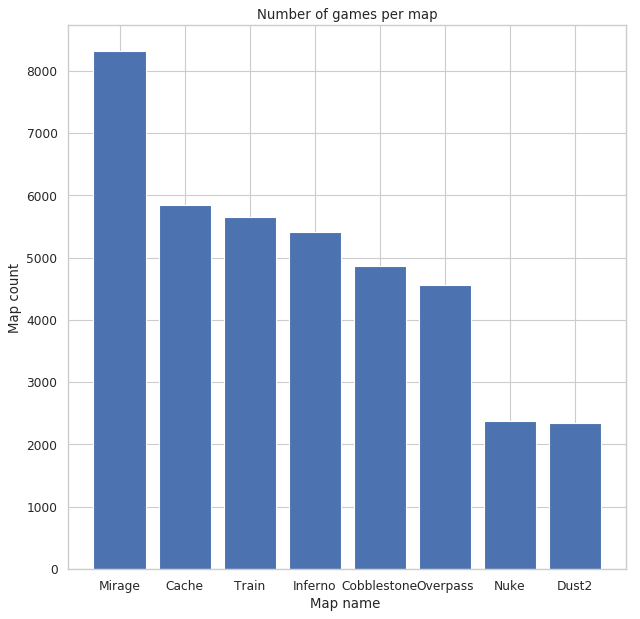

In [17]:
maps_count = df.maps.value_counts().reset_index()
maps_count = df.maps.value_counts().reset_index()
maps_count.columns = ['map_name', 'map_count']
plt.figure(figsize=(9, 9), dpi=80)
plt.bar(maps_count.map_name, maps_count.map_count)
plt.xlabel('Map name ')
plt.ylabel('Map count')
plt.title('Number of games per map')
plt.show()

The most popular map is a Mirage. The least popular maps are Nuke and Dust2. This is partly due to the fact that in recent years they have been outside the official map pool. The reason was the change in the graphic appearance of the map. There are no major differences between the other maps.

## Does it matter whether we play counter-terrorist or terrorist side on a particular map?
[Table of content](#Table-of-content)

In [18]:
hfs = df.groupby(['fist_half_home_side','maps']).home_first_score.sum().reset_index()
ass = df.groupby(['fist_half_home_side','maps']).away_second_score.sum().reset_index()
hss = df.groupby(['fist_half_home_side','maps']).home_second_score.sum().reset_index()
afs = df.groupby(['fist_half_home_side','maps']).away_first_score.sum().reset_index()
ct_1 = hfs[hfs.fist_half_home_side == 0].home_first_score + ass[ass.fist_half_home_side == 0].away_second_score #ct
t_1 = hfs[hfs.fist_half_home_side == 1].home_first_score + ass[ass.fist_half_home_side == 1].away_second_score #t
t_2 = hss[hss.fist_half_home_side == 0].home_second_score + afs[afs.fist_half_home_side == 0].away_first_score #t
ct_2 = hss[hss.fist_half_home_side == 1].home_second_score + afs[afs.fist_half_home_side == 1].away_first_score #ct
ct_1 = ct_1.reset_index().drop('index', axis=1)
ct_2 = ct_2.reset_index().drop('index', axis=1)
t_1 = t_1.reset_index().drop('index', axis=1)
t_2 = t_2.reset_index().drop('index', axis=1)
ct_terro_percent = pd.DataFrame
ct_terro_percent = t_1 +t_2
ct_terro_percent.columns = ['terro_won_total']
ct_terro_percent['maps'] = afs[afs.fist_half_home_side == 0].maps
ct_terro_percent['ct_won_total'] = (ct_1 + ct_2)
ct_terro_percent['total_rounds'] = (ct_1 + ct_2) + (t_1 + t_2)


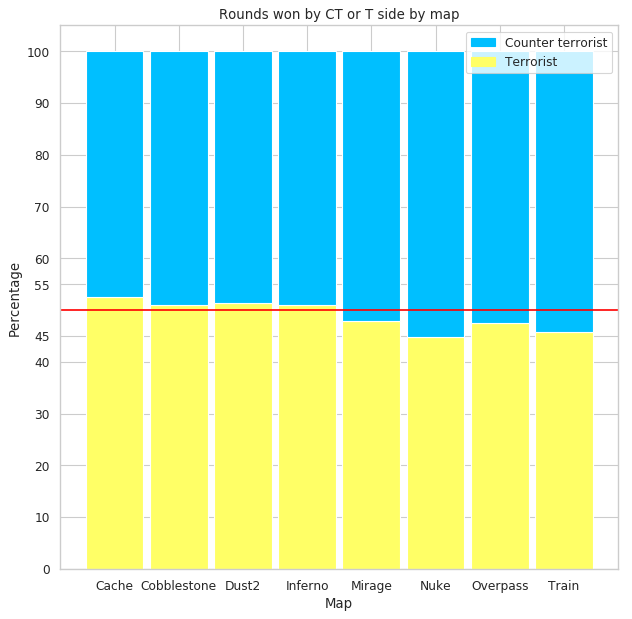

In [19]:
r = [0,1,2,3,4,5,6,7]
terro_percent = [i / j * 100 for i,j in zip(ct_terro_percent['terro_won_total'], ct_terro_percent['total_rounds'])]
ct_percent = [i / j * 100 for i,j in zip(ct_terro_percent['ct_won_total'], ct_terro_percent['total_rounds'])]
plt.figure(figsize=(9, 9), dpi=80)
barWidth = 0.9
names = ('Cache','Cobblestone','Dust2','Inferno','Mirage', 'Nuke','Overpass','Train',)
plt.bar(r, terro_percent, color='#FFFF66', edgecolor='white', width=barWidth)
plt.bar(r, ct_percent, bottom=terro_percent, color='#00BFFF', edgecolor='white', width=barWidth)
plt.xticks(r, names)
plt.xlabel("Map")
plt.ylabel("Percentage")
plt.title("Rounds won by CT or T side by map")
blue_patch = mpatches.Patch(color='#00BFFF', label='Counter terrorist')
yellow_patch = mpatches.Patch(color='#FFFF66', label='Terrorist')
plt.legend(handles=[blue_patch, yellow_patch])
plt.yticks([0,10,20,30,40,45,55,60,70,80,90,100])
plt.axhline(y=50, color="red")
plt.show()

Only one map clearly favors terrorist side(Cache), while Mirage, Overpass, Train, and Nuke are maps that are easier to play on the counter-terrorist side. Especially Nuke and Train - the defending side wins around 55% of the rounds played on these maps.

## Does the advantage after the first half guarantee winning the map?
[Table of content](#Table-of-content)

In this case, I will check if the advantage after the first half can guarantee winning the whole map. Overtime will be treated as "not winning".

In [20]:
overtime_count = df[(df.home_first_score + df.home_second_score) == (df.away_first_score + df.away_second_score)].shape[0]
adventage_won_home = df[(df.home_first_score > df.away_first_score) & ((df.home_first_score + df.home_second_score) > (df.away_first_score+ df.away_second_score))].shape[0]
adventage_won_away = df[(df.home_first_score < df.away_first_score) & ((df.home_first_score + df.home_second_score) < (df.away_first_score+ df.away_second_score))].shape[0]
total_matches = df.shape[0]
adv_won_percent = round((adventage_won_away + adventage_won_home) / total_matches *100, 2)
overtime_percent = round(overtime_count / total_matches * 100, 2)
adv_lost_percent = round(100-(adv_won_percent+overtime_percent), 2)
print("Winning the map after winning the first half occurred in " +str(adv_won_percent) + "% cases")
print("Overtime was the case in " +str(overtime_percent) + "% matches")
print("Loosing map after adventage after first half: " +str(adv_lost_percent) + "%")

Winning the map after winning the first half occurred in 73.76% cases
Overtime was the case in 8.68% matches
Loosing map after adventage after first half: 17.56%


Almost 3/4 matches are won in regular time by the team leading after the first half.

# Predicting match outcome
[Table of content](#Table-of-content)

## Feature engineering
[Table of content](#Table-of-content)

In this case, I consider only LAN events.

In [21]:
# reading dataframes

In [22]:
df_events = pd.read_csv(EVENT_PATH)

In [23]:
df_matches = pd.read_csv(MATCHES_PATH, low_memory=False)

In [24]:
df_ranking = pd.read_csv(RANKING_PATH)

In [25]:
# getting event/tournament id from link

In [26]:
df_events.columns.values

array(['event_link', 'event_name', 'event_teams_count', 'event_prize',
       'event_type', 'prize_pool', 'location', 'teams_placement_list',
       'year', 'month', 'day', 'prize_money', 'country', 'city'],
      dtype=object)

In [27]:
df_events['event_id'] = df_events.event_link.str.split("/")

In [28]:
events_id = df_events.event_id.reset_index()

In [29]:
events_id.columns = ['h_index', 'event_id']

In [30]:
for h_index in events_id.h_index:
    df_events.loc[h_index, 'event_id'] = df_events.loc[h_index].event_id[4]

In [31]:
df_events.event_id.head(3)

0    4061
1    4068
2    4070
Name: event_id, dtype: object

In [32]:
# combining dataframes - matches with events by event id - 

In [33]:
event_id_list = df_events.event_id.astype(int).tolist()

In [34]:
df_event_matches = pd.DataFrame

In [35]:
df_matches.shape

(39381, 143)

In [36]:
# This loop is taking some time so after the first launch, I saved the data frame to CSV file

# for event_id in range(0, len(df_matches.tournament_id)-1):
#     if not df_matches.loc[event_id].tournament_id in event_id_list:
#         df_matches = df_matches.drop(event_id)
# df_matches.to_csv('matches_to_model.csv', index=False)
df_matches = pd.read_csv('../input/cs-go-matches-to-model-clean/matches_to_model.csv', low_memory=False)

In [37]:
df_matches.shape

(10698, 143)

In [38]:
df_matches = df_matches.reset_index().drop("index", axis=1)

In [39]:
df_matches.columns.values

array(['match_id', 'match_link', 'match_time', 'home_team_country',
       'away_team_country', 'home_team_name', 'away_team_name',
       'home_team_link', 'away_team_link', 'match_notes',
       'match_demo_link', 'tournament_id', 'tournament_link', 'vote_ban',
       'maps', 'home_team_id', 'away_team_id', 'home_first_score',
       'away_first_score', 'home_second_score', 'away_second_score',
       'home_team_score', 'away_team_score', 'stats_link',
       'home_first_kills', 'away_first_kills', 'home_clutches_won',
       'away_clutches_won', 'ht_p1_id', 'ht_p1_name', 'ht_p1_link',
       'ht_p1_kills', 'ht_p1_headshots', 'ht_p1_asists', 'ht_p1_deaths',
       'ht_p1_kast', 'ht_p1_adr', 'ht_p1_fk_diff', 'ht_p1_rating20',
       'ht_p2_id', 'ht_p2_name', 'ht_p2_link', 'ht_p2_kills',
       'ht_p2_headshots', 'ht_p2_asists', 'ht_p2_deaths', 'ht_p2_kast',
       'ht_p2_adr', 'ht_p2_fk_diff', 'ht_p2_rating20', 'ht_p3_id',
       'ht_p3_name', 'ht_p3_link', 'ht_p3_kills', 'ht_p3_heads

Variables used to create data for model:
    - best_of - game type
    - fist_half_home_side - first side for home team
    - maps - map on which game is played
    - year - year in which the match was played
    - month - month in which the match was played
    - home_team_id - Unique home team id
    - away_team_id - Unique away team id
    - ht_p1_id - Unique home player 1 id, player 2 id...
    - at_p1_id - Unique away player 1 id...
    - home_first_score - first half score for home team
    - away_first_score - first half score for away team
    
    Other variables were used for creating target variable - who won the match

In [40]:
df_work_data = df_matches[['best_of','fist_half_home_side','maps',
                           'year','month','home_team_id','away_team_id',
                           'ht_p1_id','ht_p2_id','ht_p3_id','ht_p4_id','ht_p5_id',
                           'at_p1_id','at_p2_id','at_p3_id','at_p4_id','at_p5_id',
                           'home_first_score','away_first_score','home_second_score','away_second_score',
                           'home_team_score','away_team_score']]

Due to missing information in matches dataset, I have to drop maps with overtime - in bo3, there is no option to tell if the particular map was won by the home team or away team. Overtimes with bo1 type are still used.

In [41]:
sel_rows = df_work_data[(((df_work_data.home_first_score + df_work_data.home_second_score) == 
              (df_work_data.away_first_score + df_work_data.away_second_score)) 
             & (df_work_data.best_of == 3))].index

In [42]:
df_work_data = df_work_data.drop(sel_rows, axis=0)

In [43]:
df_work_data.shape

(10054, 23)

In [44]:
# Target values for binary classification - home team win/lose

In [45]:
df_work_data['target'] = np.where(df_work_data.home_team_score > df_work_data.away_team_score, 1, 0)

In [46]:
df_work_data.columns.values

array(['best_of', 'fist_half_home_side', 'maps', 'year', 'month',
       'home_team_id', 'away_team_id', 'ht_p1_id', 'ht_p2_id', 'ht_p3_id',
       'ht_p4_id', 'ht_p5_id', 'at_p1_id', 'at_p2_id', 'at_p3_id',
       'at_p4_id', 'at_p5_id', 'home_first_score', 'away_first_score',
       'home_second_score', 'away_second_score', 'home_team_score',
       'away_team_score', 'target'], dtype=object)

In [47]:
df_work_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10054 entries, 0 to 10697
Data columns (total 24 columns):
best_of                10054 non-null int64
fist_half_home_side    10054 non-null int64
maps                   10054 non-null object
year                   10054 non-null int64
month                  10054 non-null int64
home_team_id           10054 non-null int64
away_team_id           10054 non-null int64
ht_p1_id               10054 non-null int64
ht_p2_id               10054 non-null int64
ht_p3_id               10054 non-null int64
ht_p4_id               10054 non-null int64
ht_p5_id               10054 non-null int64
at_p1_id               10054 non-null int64
at_p2_id               10054 non-null int64
at_p3_id               10054 non-null int64
at_p4_id               10054 non-null int64
at_p5_id               10054 non-null int64
home_first_score       10054 non-null int64
away_first_score       10054 non-null int64
home_second_score      10054 non-null int64
away_secon

## Preparing data for prediction model
[Table of content](#Table-of-content)

In [48]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # splits data set into Train/Test.

In [49]:
lb_enc = LabelEncoder()

In [50]:
df_work_data["maps"] = lb_enc.fit_transform(df_work_data["maps"])

In [51]:
df_work_data = df_work_data.drop(['home_second_score', 'away_second_score',
                    'home_team_score', 'away_team_score'], axis =1 )

In [52]:
df_work_data.columns.values

array(['best_of', 'fist_half_home_side', 'maps', 'year', 'month',
       'home_team_id', 'away_team_id', 'ht_p1_id', 'ht_p2_id', 'ht_p3_id',
       'ht_p4_id', 'ht_p5_id', 'at_p1_id', 'at_p2_id', 'at_p3_id',
       'at_p4_id', 'at_p5_id', 'home_first_score', 'away_first_score',
       'target'], dtype=object)

In [53]:
y = df_work_data['target']
X = df_work_data.drop('target', axis=1)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=123)

## Predicting match based on half time score
[Table of content](#Table-of-content)

In [55]:
from keras.layers import Dense
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
from keras import Sequential
from keras.layers import Dropout
import xgboost as xgb
import time

Using TensorFlow backend.


## XGBOOSTING matches
[Table of content](#Table-of-content)

In [56]:
def XGBoost(X_train,X_test,y_train,y_test,num_rounds=500):
    dtrain = xgb.DMatrix(X_train,label=y_train)
    dtest = xgb.DMatrix(X_test,label=y_test)

    return xgb.train(params={
                    'tree_method':'gpu_exact',
                    'eval_metric':'error',
                    'objective':'gpu:binary:logistic'}
                    ,dtrain=dtrain,num_boost_round=num_rounds, 
                    early_stopping_rounds=50,evals=[(dtest,'test')],)

In [57]:
xgbm = XGBoost(X_train,X_test,y_train,y_test) # For output, click on the code button

[17:12:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[0]	test-error:0.27336
Will train until test-error hasn't improved in 50 rounds.
[17:12:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[1]	test-error:0.272366
[17:12:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[2]	test-error:0.26839
[17:12:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[3]	test-error:0.261431
[17:12:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[4]	test-error:0.258449
[17:12:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[5]	test-error:0.252485
[17:12:27] /workspace/src/tree/updater_prune.cc:74: tree

[17:12:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[55]	test-error:0.22664
[17:12:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[56]	test-error:0.228628
[17:12:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[57]	test-error:0.227634
[17:12:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[58]	test-error:0.225646
[17:12:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[59]	test-error:0.222664
[17:12:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[60]	test-error:0.225646
[17:12:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned no

[17:12:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[110]	test-error:0.230616
[17:12:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[111]	test-error:0.230616
[17:12:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[112]	test-error:0.232604
[17:12:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[113]	test-error:0.233598
Stopping. Best iteration:
[63]	test-error:0.22167



The first run of xgboost gives ~22% error rate, on the LAN matches after the first half. Having only a few data points in dataset I think this is a pretty good result.

## XGBOOST Tuning
[Table of content](#Table-of-content)

Dataset is small and one model with GPU support is trained in ~1 second, so why not try grid search with xgboost?

In [58]:
iter_ = 0 
best_error = 0
best_iter = 0
best_model = None

col_sample_rates = [1]
subsamples = [1]
etas = [0.1]
max_depths = [8]
reg_alphas = [0.004]
reg_lambdas = [0.001]
min_child_weights = [3]
ntrees = [3000]

total_models = len(col_sample_rates)*len(subsamples)*len(etas)*len(max_depths)*len(reg_alphas) *len(reg_lambdas)*len(ntrees)*len(min_child_weights)
best_error = 1
dtrain = xgb.DMatrix(X_train,label=y_train)
dtest = xgb.DMatrix(X_test,label=y_test)
# determine mean y value in training
# y_mean = train[y].mean()

for col_sample_rate in col_sample_rates:
    for subsample in subsamples:
        for eta in etas:
            for max_depth in max_depths:
                for reg_alpha in reg_alphas:
                    for reg_lambda in reg_lambdas:
                        for ntree in ntrees:
                            for min_child_weight in min_child_weights:
                                tic = time.time()

                                print('---------- ---------')

                                print('Training model %d of %d ...' % (iter_ + 1, total_models))
                                print('col_sample_rate =', col_sample_rate)
                                print('subsample =', subsample)
                                print('eta =', eta)
                                print('max_depth =', max_depth)
                                print('reg_alpha =', reg_alpha)
                                print('reg_lambda =', reg_lambda)
                                print('ntree =', ntree)
                                print('min_child_weights = ', min_child_weight)

                                params = {
                                     'booster': 'gbtree',
                                     'colsample_bytree': col_sample_rate,
                                     'eta': eta,
                                     'max_depth': max_depth,
                                     'nthread': -1,
                                     'min_child_weight': min_child_weight,
                                     'reg_alpha': reg_alpha,
                                     'reg_lambda': reg_lambda,
                                     'seed': 12345,
                                     'silent': 1,
                                     'n_estimators':ntree,
                                     'tree_method':'gpu_exact',
                                     'eval_metric':'error',
                                     'objective':'gpu:binary:logistic',
                                     'subsample': subsample}

                                watchlist = [(dtrain, 'train'), (dtest, 'eval')]

                                model = xgb.train(
                                                params, 
                                                dtrain, 
                                                ntree,
                                                early_stopping_rounds=100,
                                                evals=watchlist, 
                                                verbose_eval=False)

                                print('Model %d trained in %.2f s.'  % (iter_, time.time()-tic))
                                print('Model %d best score = %.4f' % (iter_, model.best_score))

                                if model.best_score < best_error:
                                    best_error = model.best_score
                                    best_iter = iter_
                                    best_model = model 
                                    print('Best so far!!!')
                                    print('Best error =', best_error)


                                iter_ += 1

print('Best model found at iteration: %d, with error: %.4f.' % (best_iter + 1, best_error))   

---------- ---------
Training model 1 of 1 ...
col_sample_rate = 1
subsample = 1
eta = 0.1
max_depth = 8
reg_alpha = 0.004
reg_lambda = 0.001
ntree = 3000
min_child_weights =  3
Model 0 trained in 1.44 s.
Model 0 best score = 0.2306
Best so far!!!
Best error = 0.230616
Best model found at iteration: 1, with error: 0.2306.


Model was pre trained, I've left only best parameters in grid search. A score is the same as in case of default settings.

## Multilayer perceptron
[Table of content](#Table-of-content)

In [59]:
model = Sequential()
model.add(Dense(19, activation="relu",input_shape=(19,)))
model.add(Dense(15,activation="tanh"))
model.add(Dense(2))
model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

In [60]:
model.fit(x=X_train,y=y_train,batch_size=100,epochs=5)

Epoch 1/5
9048/9048 [==============================] - 1s 63us/step - loss: 4.7009 - acc: 0.5244
Epoch 2/5
9048/9048 [==============================] - 0s 34us/step - loss: 3.1282 - acc: 0.5183
Epoch 3/5
9048/9048 [==============================] - 0s 35us/step - loss: 3.4528 - acc: 0.5183
Epoch 4/5
9048/9048 [==============================] - 0s 32us/step - loss: 3.2104 - acc: 0.5298
Epoch 5/5
9048/9048 [==============================] - 1s 60us/step - loss: 4.1293 - acc: 0.5431


Accuracy score with MLP is very low (comparing to xgboost), but what to expect with a dataset that small.